In [1]:
import rhessys.utilities as rut
import statsmodels.api as sm

In [2]:
tmp = pd.read_pickle('./data/cosmos_p_from_swe.pcl')
datmin = tmp.index[0]
datmax = tmp.index[-1]

In [3]:
tmp['wateryear'] = tmp.index.map(rut.wateryear)

In [4]:
tmp.head()

,P,Tave,Tmax,Tmin,wateryear
2009-10-01,0.0,3.333124,10.290975,-3.624726,2010
2009-10-02,0.0,4.630947,15.133749,-5.871856,2010
2009-10-03,0.0,7.088696,16.989219,-2.811827,2010
2009-10-04,0.0,9.037910,15.559847,2.515974,2010
2009-10-05,0.0,8.546200,17.127397,-0.034997,2010


In [5]:
dat = pd.read_pickle('./data/Vcm_cosmos_pillow_swe.pcl') # swe in cm
lapsed_p = pd.read_pickle('./data/jemez_raws_lapse.pcl')[datmin:datmax] # p in mm

In [6]:
dat['wateryear'] = dat.index.map(rut.wateryear)

In [7]:
swe = dat.swe.as_matrix()*10. # cm > mm

tmp = swe[1:] - swe[0:-1]
delswe = list(tmp)
delswe.append(0)

In [8]:
dat['delswe'] = delswe

In [9]:
dat = dat.loc[datmin:datmax]

In [10]:
lapsed_p['delswe'] = dat.delswe # add the delswe variable

In [11]:
#lapsed_p.loc[np.isnan(lapsed_p.delswe),'delswe'] = 0. # zero nans

In [12]:
lapsed_p['wateryear'] = lapsed_p.index.map(rut.wateryear)

In [13]:
strts = []
nds = []

for wy in lapsed_p.wateryear.unique()[:-1]:
    tmp = lapsed_p.loc[lapsed_p.wateryear==wy]
    
    strts.append(tmp.loc[tmp.delswe!=0].index[0])
    nds.append(tmp.loc[tmp.P!=0].index[-1])

In [14]:
lapsed_p['summer'] = 1.

In [15]:
for strt,nd in zip(strts,nds):
    lapsed_p.loc[strt:nd,'summer'] = 0.

In [16]:
lapsed_p.head()

,date,year,doy,dor,Tave,Tmax,Tmin,P,month,Vcm_tmin,Vcm_tave,Vcm_tmax,Vcm_p,Vcm_rain_duration,delswe,wateryear,summer
2009-10-01,10/01/2009,2009,274,2558,4.7,11.7,-0.6,0.0,10,-0.709345,2.936486,7.834244,1.647283,1.176688,NaN,2010,0.0
2009-10-02,10/02/2009,2009,275,2559,7.0,16.1,-2.2,0.0,10,-2.309345,5.236486,12.234244,1.647283,1.176688,NaN,2010,0.0
2009-10-03,10/03/2009,2009,276,2560,9.5,17.8,0.6,0.0,10,0.490655,7.736486,13.934244,1.647283,1.176688,NaN,2010,0.0
2009-10-04,10/04/2009,2009,277,2561,10.1,17.2,5.6,0.0,10,5.490655,8.336486,13.334244,1.647283,1.176688,NaN,2010,0.0
2009-10-05,10/05/2009,2009,278,2562,10.6,18.3,3.3,0.0,10,3.190655,8.836486,14.434244,1.647283,1.176688,NaN,2010,0.0


In [17]:
lapsed_p.tail()

,date,year,doy,dor,Tave,Tmax,Tmin,P,month,Vcm_tmin,Vcm_tave,Vcm_tmax,Vcm_p,Vcm_rain_duration,delswe,wateryear,summer
2012-10-01,10/01/2012,2012,275,3654,12.7,21.7,5.6,0.0,10,5.490655,10.936486,17.834244,1.647283,1.176688,NaN,2013,1.0
2012-10-02,10/02/2012,2012,276,3655,13.2,22.2,3.3,0.0,10,3.190655,11.436486,18.334244,1.647283,1.176688,NaN,2013,1.0
2012-10-03,10/03/2012,2012,277,3656,15.9,22.8,10.0,0.0,10,9.890655,14.136486,18.934244,1.647283,1.176688,NaN,2013,1.0
2012-10-04,10/04/2012,2012,278,3657,14.9,22.8,6.7,0.0,10,6.590655,13.136486,18.934244,1.647283,1.176688,NaN,2013,1.0
2012-10-05,10/05/2012,2012,279,3658,13.5,20.0,5.6,0.0,10,5.490655,11.736486,16.134244,1.647283,1.176688,NaN,2013,1.0


In [18]:
def hybrid_p(df):
    p = df.Vcm_p
    delswe = df.delswe
    summer = df.summer
    
    # if p and delswe are positve, return accumulation from the pillow
    if (p>0) & (delswe>0):
        return delswe
    
    # if p is greater than 0 and snow is melting return the precipitation
    if (p>0) & (delswe<0):
        return p
    
    # if both snow and precip are zero, return zero
    if (p==0) & (delswe==0):
        return 0
    
    # if p is zero and there is snow accumulation, return accumulation
    if (p==0) & (delswe>0):
        return delswe
    
    # if the precip occures during summer, return p
    if np.isnan(delswe):
        return p

In [19]:
lapsed_p['hybrid_p'] = lapsed_p.apply(hybrid_p,axis=1)

In [20]:
lapsed_p['diff_p'] = lapsed_p.Vcm_p - lapsed_p.hybrid_p

In [21]:
lapsed_p.loc[np.isnan(lapsed_p.hybrid_p),'hybrid_p'] = 0 # make nans 0

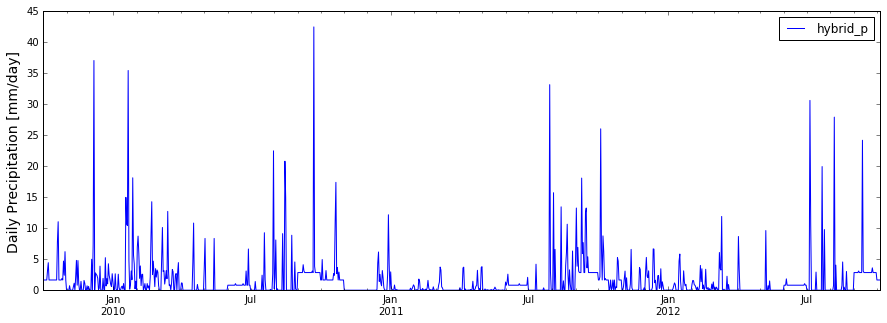

In [22]:
plt.figure(figsize=(15,5))
lapsed_p.hybrid_p.plot()
#lapsed_p.Vcm_p.plot()
plt.ylabel('Daily Precipitation [mm/day]',fontsize=14)
plt.legend()

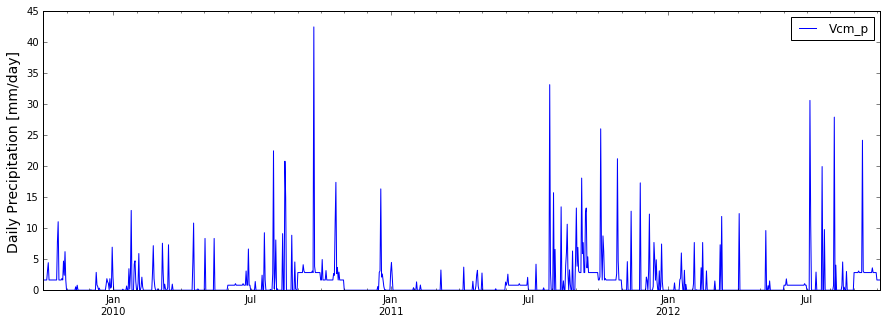

In [23]:
plt.figure(figsize=(15,5))
#lapsed_p.hybrid_p.plot()
lapsed_p.Vcm_p.plot()
plt.ylabel('Daily Precipitation [mm/day]',fontsize=14)
plt.legend()

In [24]:
lapsed_p.columns

Index([u'date', u'year', u'doy', u'dor', u'Tave', u'Tmax', u'Tmin', u'P',
       u'month', u'Vcm_tmin', u'Vcm_tave', u'Vcm_tmax', u'Vcm_p',
       u'Vcm_rain_duration', u'delswe', u'wateryear', u'summer', u'hybrid_p',
       u'diff_p'],
      dtype='object')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Vcm_rain_duration   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     5380.
Date:                Mon, 21 Nov 2016   Prob (F-statistic):               0.00
Time:                        13:25:51   Log-Likelihood:                -1006.4
No. Observations:                1101   AIC:                             2017.
Df Residuals:                    1099   BIC:                             2027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.5085      0.019     26.568      0.000         0.471     0.546
P              0.3630      0.005     73.350      0.000         0.353     0.373
==============================================================================
Omnibus:                      135.366   Durbin-Watson:                   0.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              261.638
Skew:                           0.758   Prob(JB):                     1.53e-57
Kurtosis:                       4.845   Cond. No.                         4.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

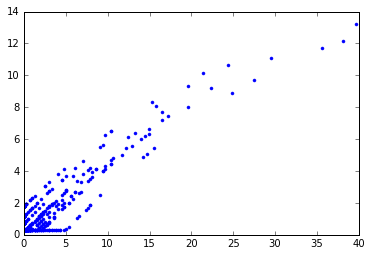

In [25]:
# make rain duration 
mod = sm.formula.ols('Vcm_rain_duration ~ P + 1',lapsed_p).fit()
plt.plot(lapsed_p.P,lapsed_p.Vcm_rain_duration,'.')
mod.summary()

In [26]:
lapsed_p['hybrid_rain_duration'] = np.ceil((mod.params['P']*lapsed_p.hybrid_p) + mod.params['P'])

In [27]:
lapsed_p.hybrid_rain_duration.describe()

count    1101.000000
mean        1.465940
std         1.333476
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        16.000000
Name: hybrid_rain_duration, dtype: float64

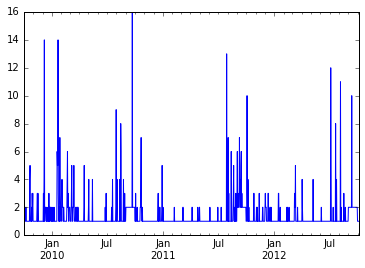

In [28]:
lapsed_p.hybrid_rain_duration.plot()

In [30]:
print lapsed_p.index.min()
print lapsed_p.index.max()

2009-10-01 00:00:00
2012-10-05 00:00:00


### Generate Long forcing

In [24]:
strt = '2006-10-01' # begining of WY2007

In [25]:
wy2010 = lapsed_p.loc[lapsed_p.wateryear==2010]
wy2011 = lapsed_p.loc[lapsed_p.wateryear==2011]
wy2012 = lapsed_p.loc[lapsed_p.wateryear==2012] # leap year

In [29]:
# remove index
wy2010.reset_index(inplace=True)
wy2011.reset_index(inplace=True)
wy2012.reset_index(inplace=True)

In [30]:
hybrid_long = pd.concat([wy2010,wy2012,wy2011,wy2010,wy2011,wy2012])

In [34]:
hybrid_long.index = pd.DatetimeIndex(pd.date_range(start=strt,periods=len(hybrid_long),freq='D'))

In [38]:
dt = hybrid_long.index.min()

header = '%s %s %s'%(dt.year,dt.month,dt.day)

np.savetxt('/RHESSys/jemez/clim/vcm_hybrid_long.rain',hybrid_long.hybrid_p/1000.,header=header,comments='',fmt='%f')
np.savetxt('/RHESSys/jemez/clim/vcm_hybrid_long.tmin',hybrid_long.Vcm_tmin,header=header,comments='',fmt='%f')
np.savetxt('/RHESSys/jemez/clim/vcm_hybrid_long.tavg',hybrid_long.Vcm_tave,header=header,comments='',fmt='%f')
np.savetxt('/RHESSys/jemez/clim/vcm_hybrid_long.tmax',hybrid_long.Vcm_tmax,header=header,comments='',fmt='%f')